In [35]:
from lasagne import layers
from lasagnekit.misc.plot_weights import dispims_color
from skimage.io import imsave
%matplotlib inline
import sys, os
sys.path.append(os.getcwd()+"/..")
from tools.system.imgtovideo import imgs_to_video
from data import load_data
import matplotlib.pyplot as plt
import numpy as np
import theano
import theano.tensor as T
from lasagne import layers as L
from lasagnekit.misc.plot_weights import dispims_color, tile_raster_images
import pandas as pd

from tqdm import tqdm
import base64
import json

from skimage.io import imread, imsave
from skimage.transform import resize

from IPython.display import HTML, Image


from tools.brushstroke.common import (
    resize_set, load_model, get_bias, 
    get_scale, build_brush_func,
    build_encode_func,
    build_image_to_code_func,
    build_code_to_image,
    to_grid_of_images,
    seq_to_video,
    embed_video,
    disp_grid,
    prop_uniques,
    hash_array,
    normalize,
    sigmoid,
    build_pointer_images)
from helpers import GenericBrushLayer

In [361]:
n_steps = 1
nb_features = 13
inp = layers.InputLayer((None, n_steps, nb_features))
patches = np.ones((1, 1, 4, 4))
patches = patches.astype(np.float32)
brush = GenericBrushLayer(
    inp,
    16, 16,
    n_steps=n_steps,
    patches=patches,
    col='grayscale',
    return_seq=False,
    reduce_func=lambda x,y:x+y,
    to_proba_func=T.nnet.softmax,
    normalize_func=T.nnet.sigmoid,
    x_sigma=0.5,
    y_sigma=0.5,
    x_stride=1,
    y_stride=1,
    patch_index=0,
    color=[1.],
    x_min=0,
    x_max='width',
    y_min=0,
    y_max='height',
    eps=0)

In [359]:
X = T.tensor3()
fn = theano.function([X], layers.get_output(brush, X))

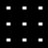

In [360]:
coord = np.zeros((9, n_steps, nb_features))
coord = coord.astype(np.float32)
coord[:]=0
y = fn(coord)
img = disp_grid(y)
imsave('out.png', img)
Image('out.png', width=400, height=400)

(array([ 23823.,   3996.,   2304.,   1548.,   1260.,   1008.,    936.,
           756.,    612.,    621.]),
 array([  5.69967753e-08,   1.59648647e-04,   3.19240298e-04,
          4.78831949e-04,   6.38423599e-04,   7.98015250e-04,
          9.57606900e-04,   1.11719855e-03,   1.27679020e-03,
          1.43638185e-03,   1.59597350e-03]),
 <a list of 10 Patch objects>)

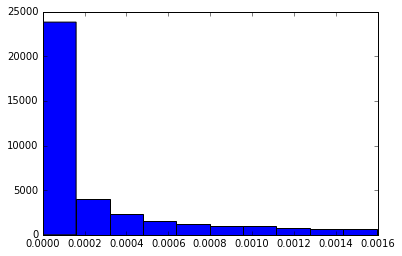

In [55]:
plt.hist(y.flatten())

array([[[[  3.57128592e-05,   4.89358790e-05,   6.63876199e-05, ...,
            8.91669697e-05,   6.63876199e-05,   4.89358790e-05],
         [  4.89358790e-05,   6.70548397e-05,   9.09682567e-05, ...,
            1.22181882e-04,   9.09682567e-05,   6.70548397e-05],
         [  6.63876199e-05,   9.09682567e-05,   1.23409787e-04, ...,
            1.65754958e-04,   1.23409787e-04,   9.09682567e-05],
         ..., 
         [  8.91669697e-05,   1.22181882e-04,   1.65754958e-04, ...,
            2.22629897e-04,   1.65754958e-04,   1.22181882e-04],
         [  6.63876199e-05,   9.09682567e-05,   1.23409787e-04, ...,
            1.65754958e-04,   1.23409787e-04,   9.09682567e-05],
         [  4.89358790e-05,   6.70548397e-05,   9.09682567e-05, ...,
            1.22181882e-04,   9.09682567e-05,   6.70548397e-05]]],


       [[[  3.57128592e-05,   4.89358790e-05,   6.63876199e-05, ...,
            8.91669697e-05,   6.63876199e-05,   4.89358790e-05],
         [  4.89358790e-05,   6.70548397e-0

(array([ 23823.,   3996.,   2304.,   1548.,   1260.,   1008.,    936.,
           756.,    612.,    621.]),
 array([  3.57128592e-05,   1.00032142e-01,   2.00028570e-01,
          3.00024999e-01,   4.00021428e-01,   5.00017856e-01,
          6.00014285e-01,   7.00010714e-01,   8.00007143e-01,
          9.00003571e-01,   1.00000000e+00]),
 <a list of 10 Patch objects>)

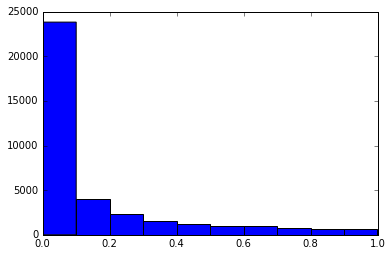

In [66]:
plt.hist((y/y.max(axis=(2,3), keepdims=True)).flatten())

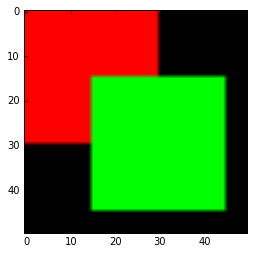

In [111]:
img1 = np.zeros((50, 50, 3))
img2 = np.zeros((50, 50, 3))
img1[0:30, 0:30] = [1,0,0]

alpha1 = np.zeros((50, 50, 3))
alpha1[0:30, 0:30]=1


img2[15:45, 15:45] = [0,1,0]
alpha2 = np.zeros((50, 50, 3))
alpha2[15:45, 15:45]=1
#alpha2=img2

#img = img1*alpha1*(1-alpha2) + img2*alpha2
img = img1*(1-alpha2) + img2 * alpha2
plt.imshow(img)